## Analyze rates_delay_loss made by test_env.py
ex. all traces (train one by one)

In [1]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob

In [2]:
# conf_name = "SAC_train_traces_one_by_one_v6" #during training, test each trace after having trained on it
# conf_name = "SAC_all_traces_1_env_v6" #after training on all, do test_env.py first with "./data/SAC_all_traces_1_env_v6/5.zip", then take a look

In [5]:

conf_name = f"test_TD3_trace_300k_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22"

In [6]:
prefix = "../output/rates_delay_loss_"
suffix = ".pickle"

pickle_path = prefix+conf_name+suffix
print(pickle_path)
l_rate = pd.read_pickle(pickle_path)
time_step = 200
reward_profile=0
print(time_step)

../output/rates_delay_loss_test_TD3_trace_300k_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22.pickle
200


In [7]:
l_rate.keys()

dict_keys(['./traces/WIRED_900kbps.json', './traces/WIRED_200kbps.json', './traces/WIRED_35mbps.json', './traces/4G_700kbps.json', './traces/4G_3mbps.json', './traces/4G_500kbps.json', './traces/5G_12mbps.json', './traces/5G_13mbps.json', './traces/trace_300k.json'])

In [9]:
l_rate['./traces/WIRED_900kbps.json'].keys()

dict_keys(['bandwidth_prediction', 'sending_rate', 'receiving_rate', 'delay', 'loss_ratio', 'log_prediction', 'reward', 'Ru', 'Rd', 'Rl'])

Trace: ./traces/5G_12mbps.json


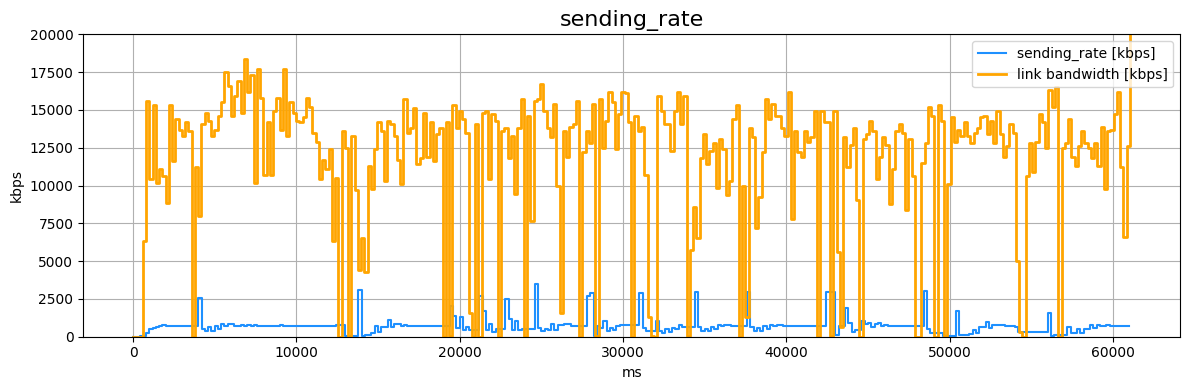

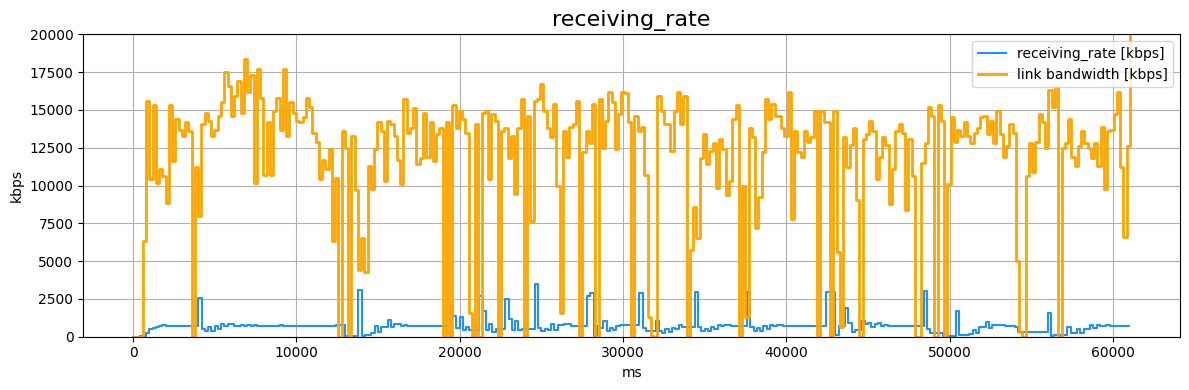

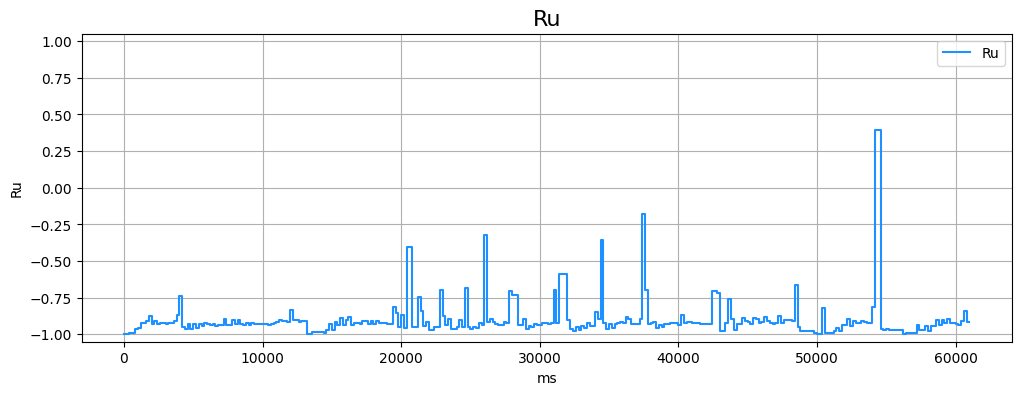

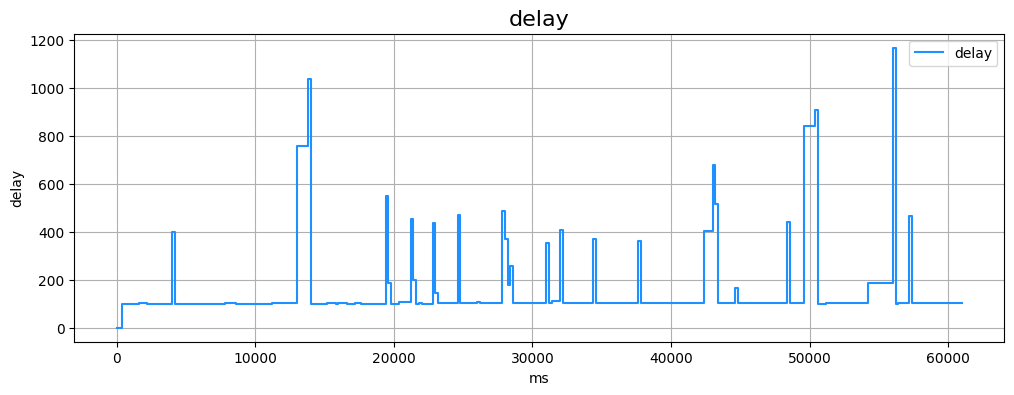

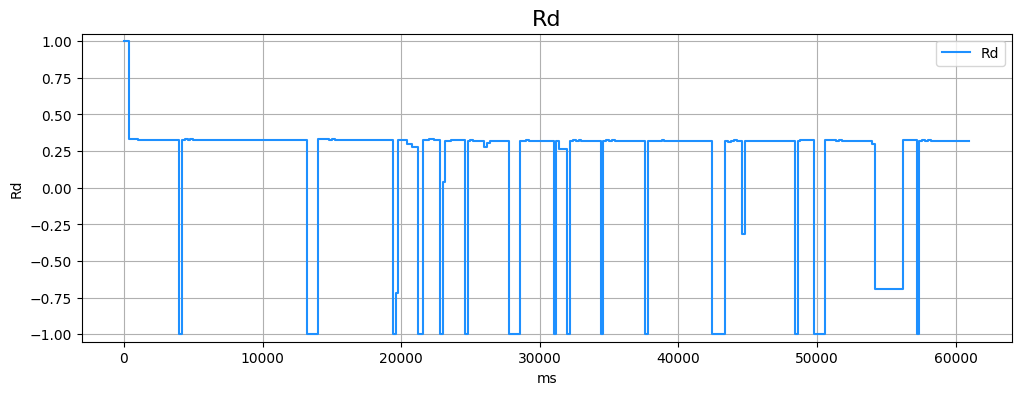

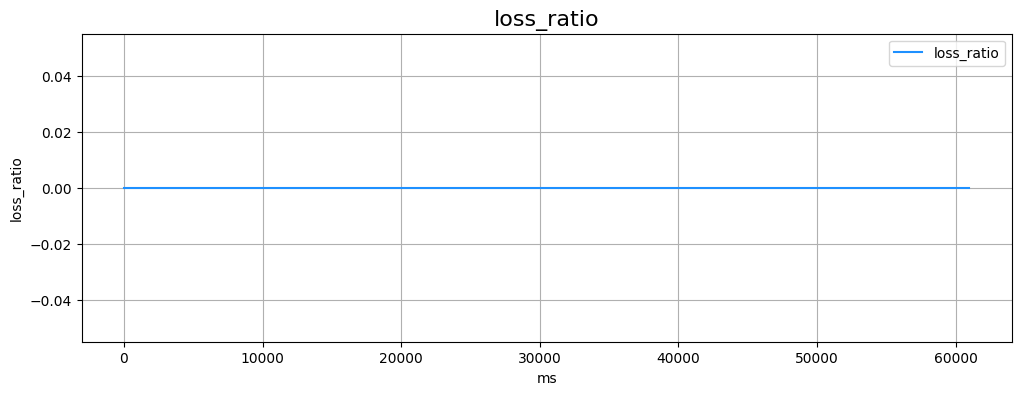

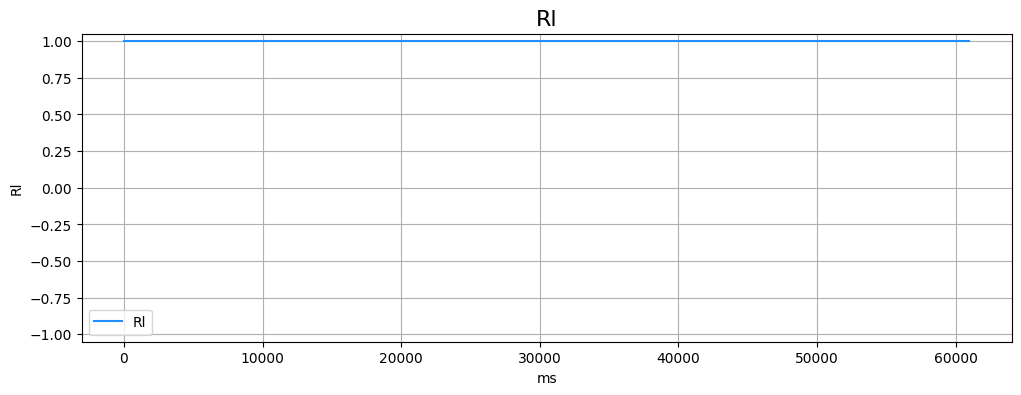

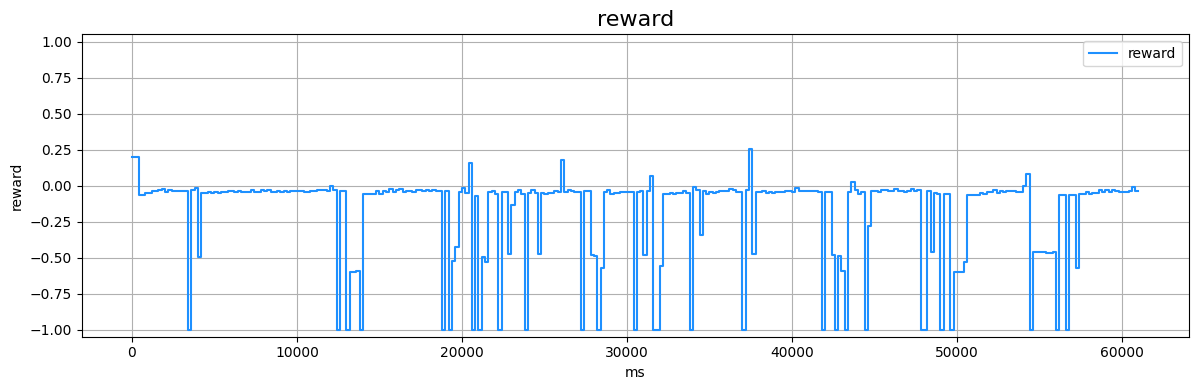



Trace: ./traces/5G_13mbps.json


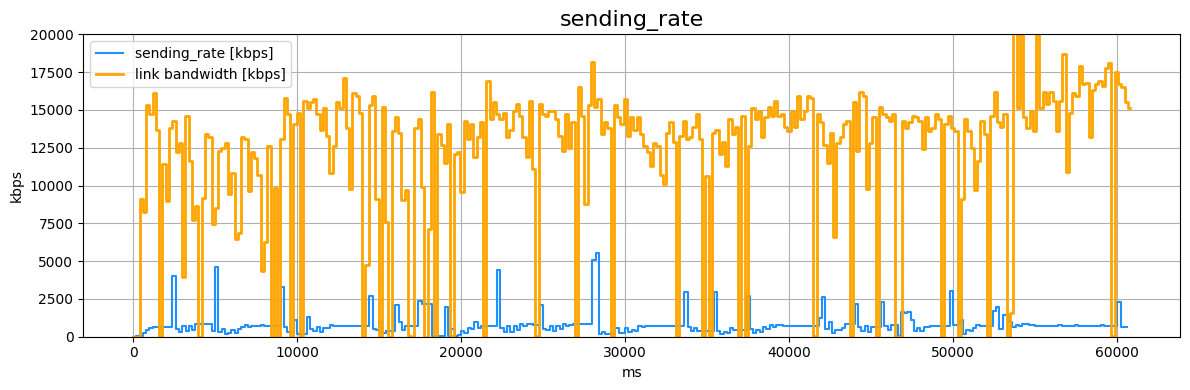

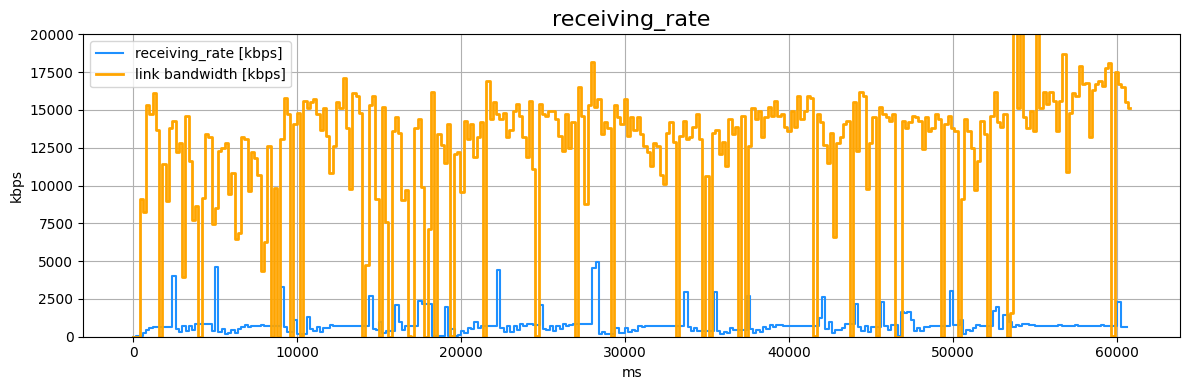

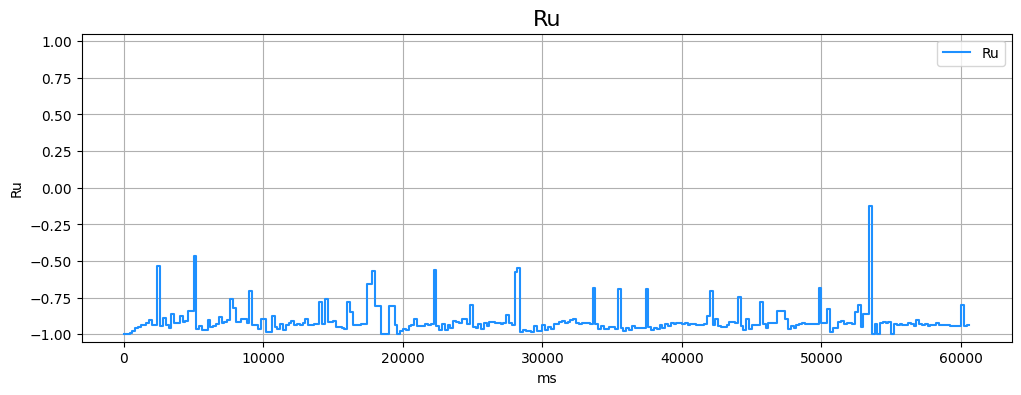

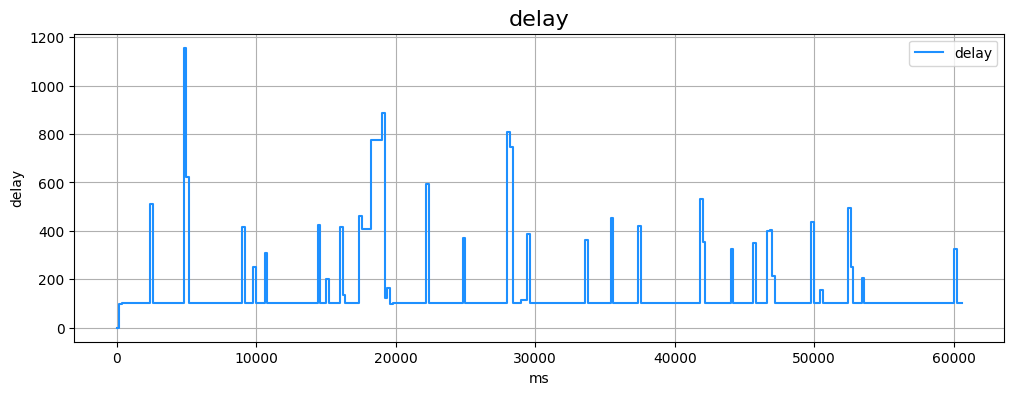

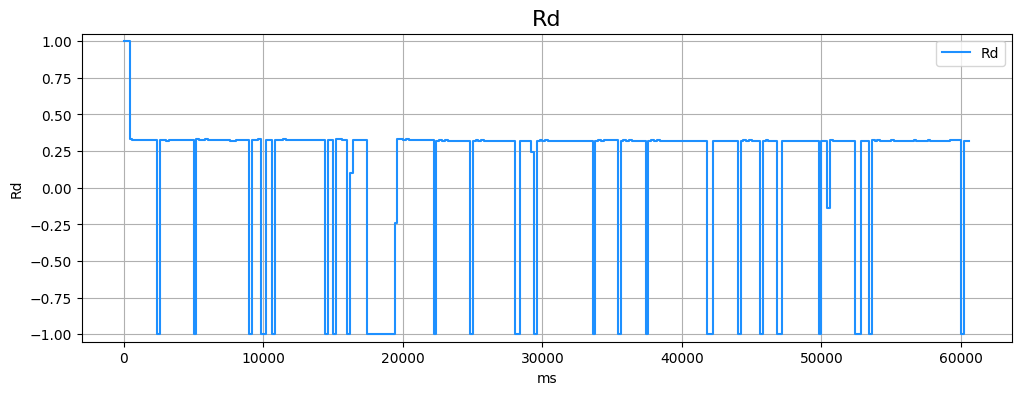

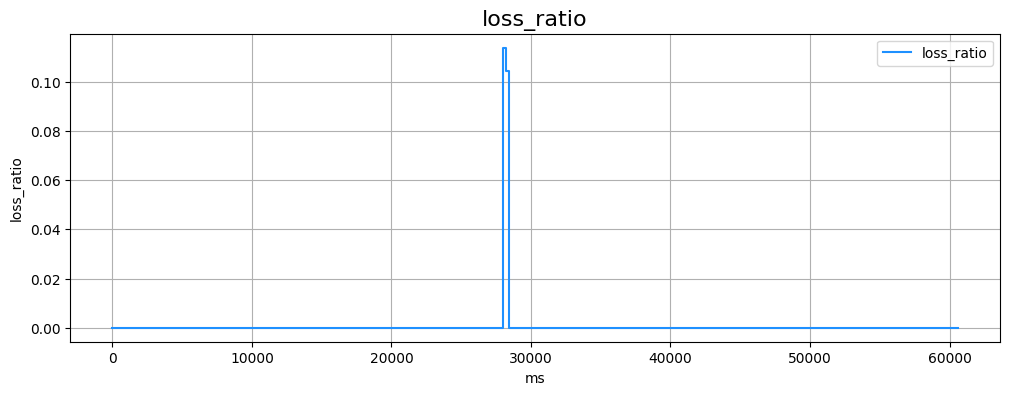

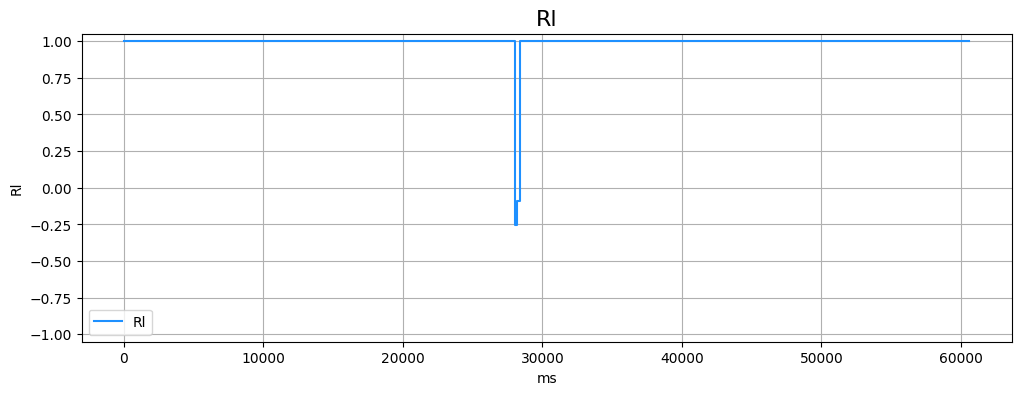

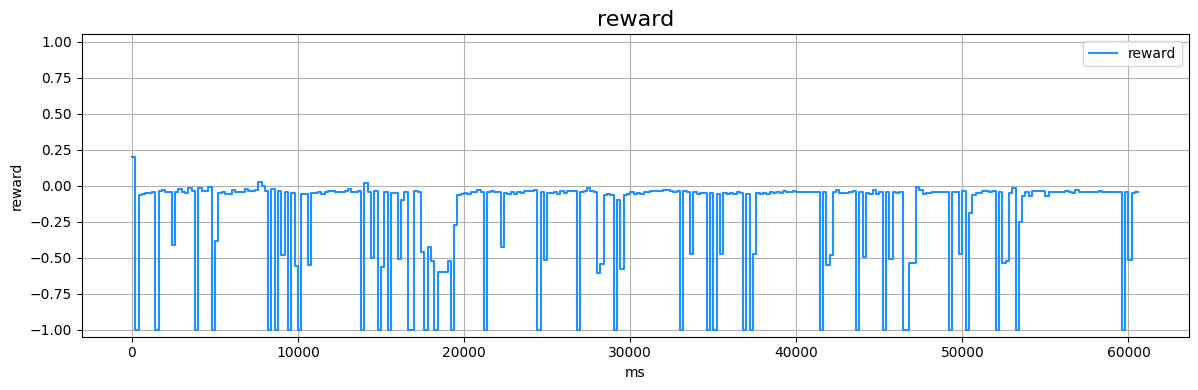



Trace: ./traces/trace_300k.json


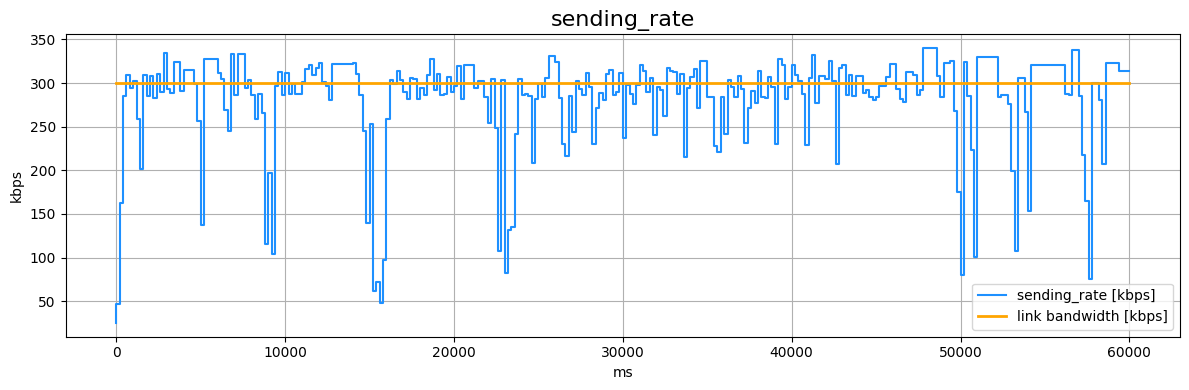

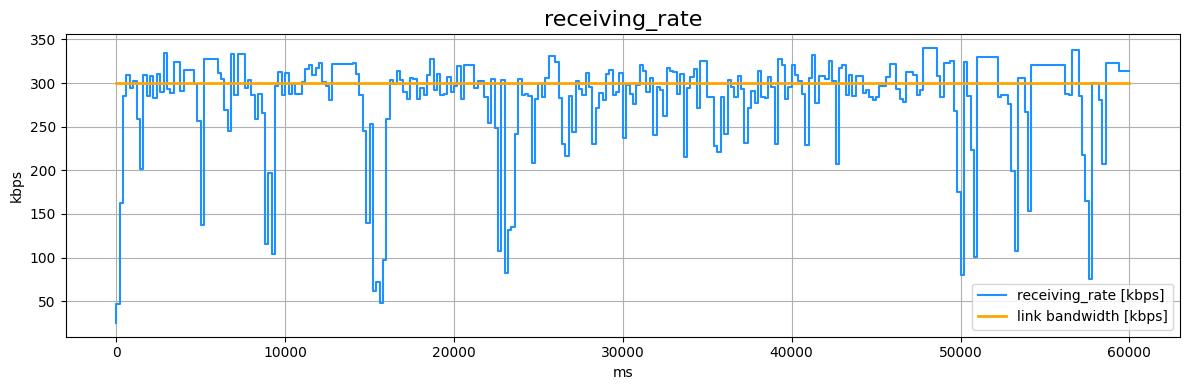

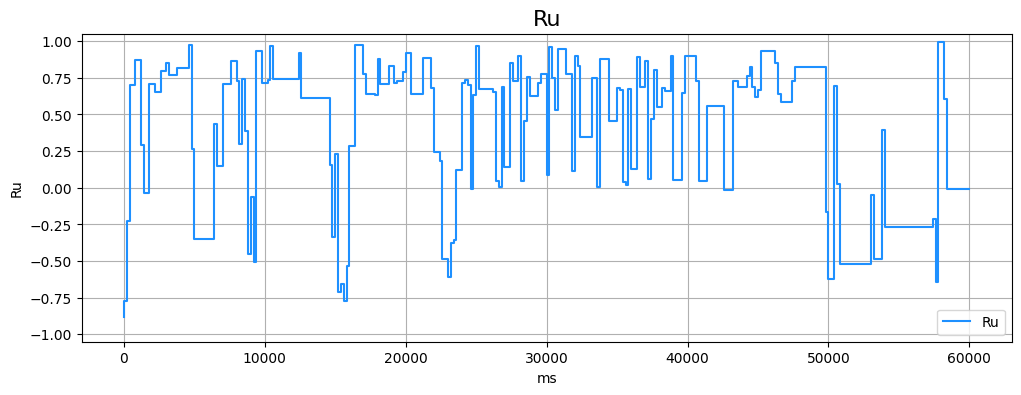

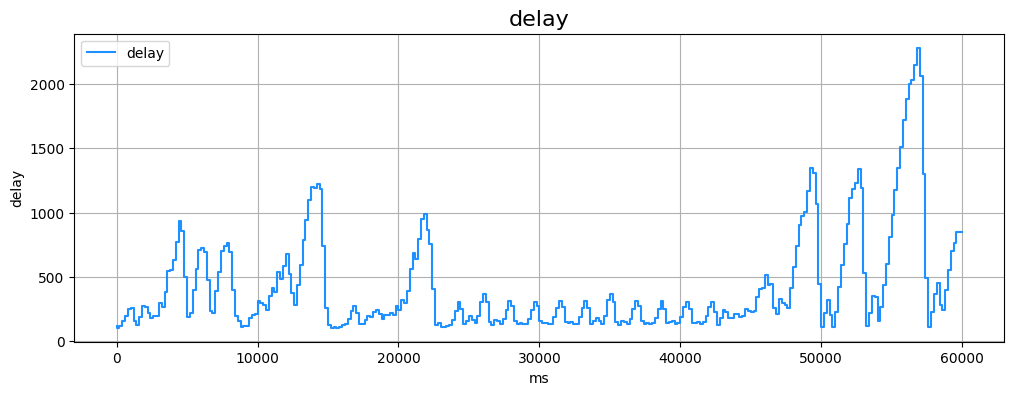

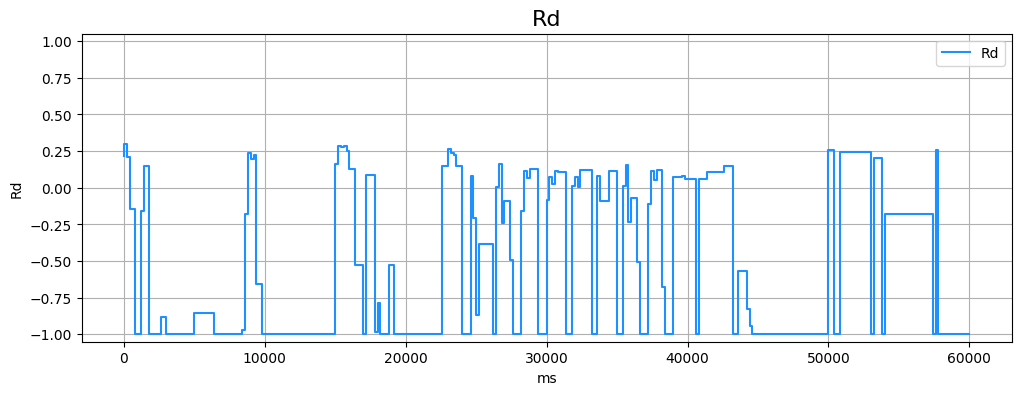

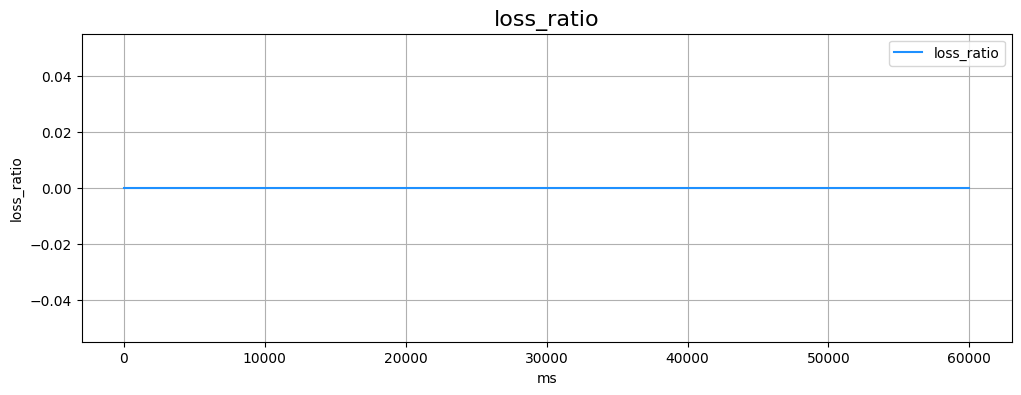

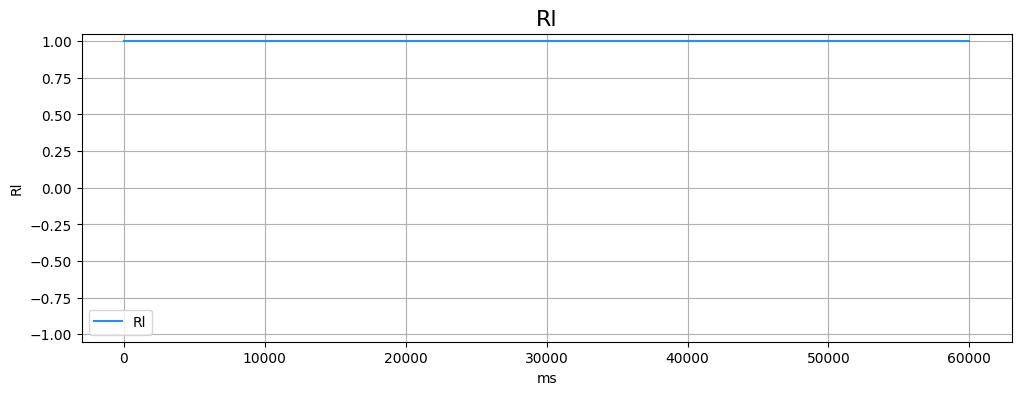

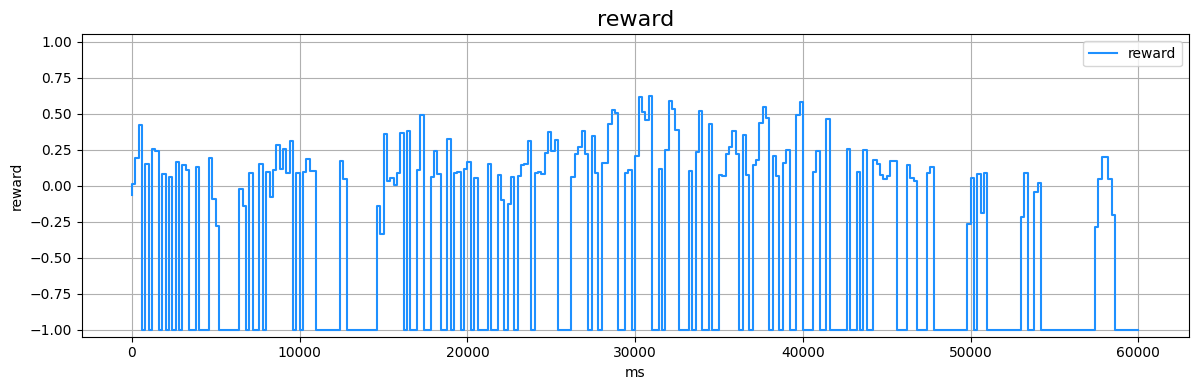

In [30]:
plot_gcc = False

for key in l_rate.keys():
    
    print(f"Trace: {key}")
    colors = iter(["dodgerblue", "teal", "indianred", "olive", "yellow", "green"])

    # for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:
    for metric in ["sending_rate", "receiving_rate", "Ru", "delay", "Rd", "loss_ratio", "Rl", "reward"]: #reward
        #Define capacity

        trace_name = "../" + key.split("/")[1] + "/" + key.split("/")[2]
        REAL_NAME = key.split("/")[2].split(".")[0]
        
        if plot_gcc:
            pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
            l_rate_gcc = pd.read_pickle(pickle_path_gcc)

            if l_rate_gcc["trace_name"] != REAL_NAME:
                print("Trace not the same as GCC")

        with open(trace_name, "r") as f:
            d = json.load(f)

        df = pd.DataFrame(d["uplink"]["trace_pattern"])
        time = [0] + list(df["duration"].cumsum())
        capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
        

        df_rate = pd.DataFrame(l_rate[key][metric], columns=[metric])
        if plot_gcc and (metric != "reward"):
            df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
            df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

        t = np.arange(len(df_rate))*time_step
        df_rate["time"] = t
        df_rate.set_index("time", inplace=True)


        if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

            plt.figure(figsize=(12,4))
            plt.title(metric, fontsize=16)
            # color=next(colors)
            plt.step(df_rate.index, df_rate[metric]/1000, label=f"{metric} [kbps]", color="dodgerblue")
            plt.step(time, capacities, lw=2, label="link bandwidth [kbps]", color="orange")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_gcc"]/1000, label=f"{metric} GCC [kbps]", color="red")
            plt.legend()
            plt.ylabel("kbps")
            plt.xlabel("ms")
            plt.grid()
            if REAL_NAME == "WIRED_200kbps":
                plt.xlim((0, 50000))
            if REAL_NAME == "WIRED_35mbps":
                plt.ylim((0, 40000))
            elif REAL_NAME == "4G_700kbps":
                plt.ylim(0, 1500)
            elif REAL_NAME == "4G_3mbps":
                plt.ylim(0,8000)
            elif REAL_NAME == "4G_500kbps":
                plt.ylim(0,1600)
            elif REAL_NAME == "5G_12mbps":
                plt.ylim(0,20000)
            elif REAL_NAME == "5G_13mbps":
                plt.ylim(0,20000)
            plt.tight_layout()

        else:
            plt.figure(figsize=(12,4))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index, df_rate[metric], label=f"{metric}", color="dodgerblue")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_gcc"], label=f"{metric} GCC", color="red")
            plt.ylabel(metric)
            plt.xlabel("ms")
            plt.legend()
            plt.grid()
            if metric == "reward":
                plt.tight_layout()
                plt.ylim(-1.05,1.05)
                plt.savefig(f"./plots/reward_{REAL_NAME}_{reward_profile}.png")
            elif metric in ["Rl", "Ru", "Rd"]:
                plt.ylim(-1.05,1.05)
            
        plt.show()
        print("\n")